<a href="https://colab.research.google.com/github/eghove/python-finance-week/blob/master/Finance_Week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Import necessary packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import sklearn
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.losses import Huber
from keras.optimizers import SGD

Using TensorFlow backend.


In [4]:
# PIP install yahoo finance
!pip install yfinance --upgrade --no-cache-dir

  Created wheel for yfinance: filename=yfinance-0.1.45-cp36-none-any.whl size=14652 sha256=716858b3f8a677f49dcaeb7b60f8bd5e78b5662ff2fa46278721772f48b1dc65
  Stored in directory: /tmp/pip-ephem-wheel-cache-lciu0fks/wheels/0c/d1/df/aa9a7744a4ac353cc9a1f2c3aaea7c1f457fc49de4286f2d88
Successfully built yfinance


In [5]:
from google.colab import drive
drive.mount('drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at drive


Now that I have Yahoo! Finance, I want to get the S&P 500 index back to 01/01/1999. Storing it to my GoogleDrive.

In [6]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf

yf.pdr_override()
dataframe = pdr.get_data_yahoo('^GSPC', start='1999-01-01').reset_index()
dataframe.to_csv('GSPC.csv', index = False)
dataframe.head(10)


[*********************100%***********************]  1 of 1 downloaded


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1,1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
2,1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
3,1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
4,1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000
5,1999-01-11,1275.089966,1276.219971,1253.339966,1263.880005,1263.880005,818000000
6,1999-01-12,1263.880005,1264.449951,1238.290039,1239.510010,1239.510010,800200000
7,1999-01-13,1239.510010,1247.750000,1205.459961,1234.400024,1234.400024,931500000
8,1999-01-14,1234.400024,1236.810059,1209.540039,1212.189941,1212.189941,797200000
9,1999-01-15,1212.189941,1243.260010,1212.189941,1243.260010,1243.260010,798100000


In [7]:
#making sure I can access the CSV file
df = pd.read_csv('GSPC.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,1229.229980,1248.810059,1219.099976,1228.099976,1228.099976,877000000
1999-01-05,1228.099976,1246.109985,1228.099976,1244.780029,1244.780029,775000000
1999-01-06,1244.780029,1272.500000,1244.780029,1272.339966,1272.339966,986900000
1999-01-07,1272.339966,1272.339966,1257.680054,1269.729980,1269.729980,863000000
1999-01-08,1269.729980,1278.239990,1261.819946,1275.089966,1275.089966,937800000


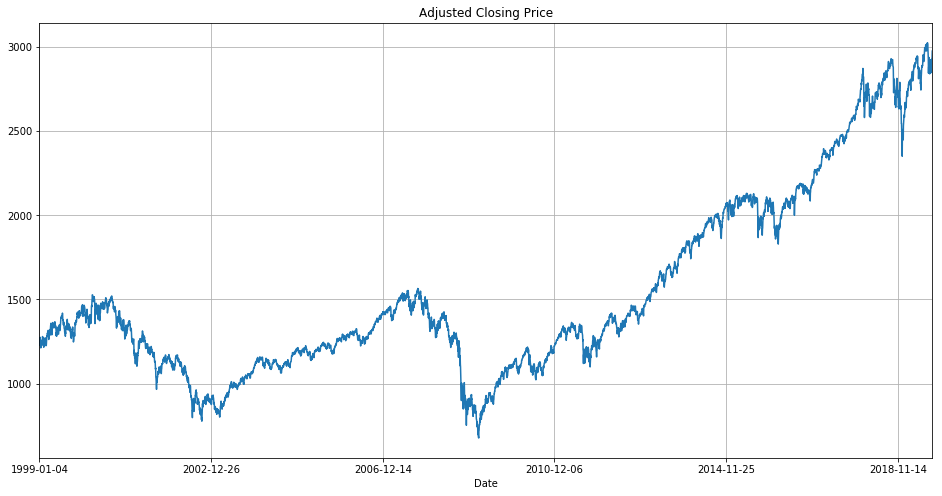

In [8]:
#plot the ADJ Close
df['Adj Close'].plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Using a window size of 32 prices to make it more robust to noise

In [0]:
window_size = 32

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

Splitting the data into train/test so the first 80% are the training set and the last 20% is the testing set.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

First, I'm going to try Ridge Regression.

In [0]:
# Train
ridge_model = Ridge()
ridge_model.fit(X_train, y_train)

# Infer
y_pred_train_ridge = ridge_model.predict(X_train)
y_pred_ridge = ridge_model.predict(X_test)

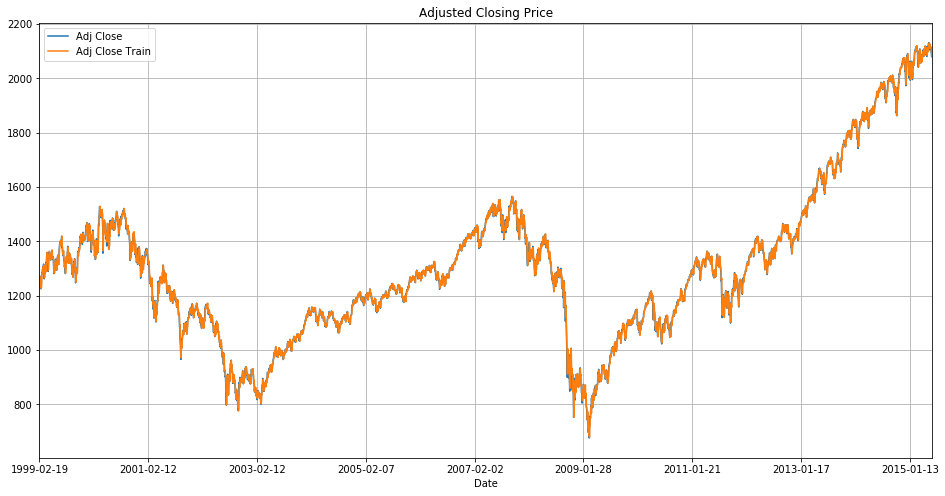

In [12]:
# Plot what it looks like for the training data
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ridge['Adj Close Train'] = y_pred_train_ridge[:-window_size]
df_ridge.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Let's use the model to check out the test data

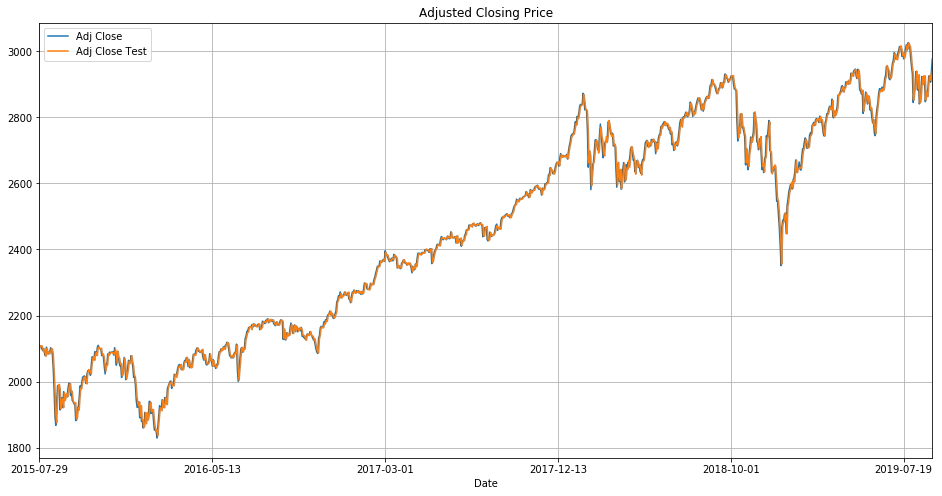

In [13]:
# Same for the test
df_ridge = df.copy()
df_ridge.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ridge = df_ridge.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ridge['Adj Close Test'] = y_pred_ridge
df_ridge.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Trying Gradient Boosting Trees

In [0]:
# Model #2 - Gradient Boosting Trees
gb_model = GradientBoostingRegressor()
gb_model.fit(X_train, y_train)

# Infer
y_pred_train_gb = gb_model.predict(X_train)
y_pred_gb = gb_model.predict(X_test)

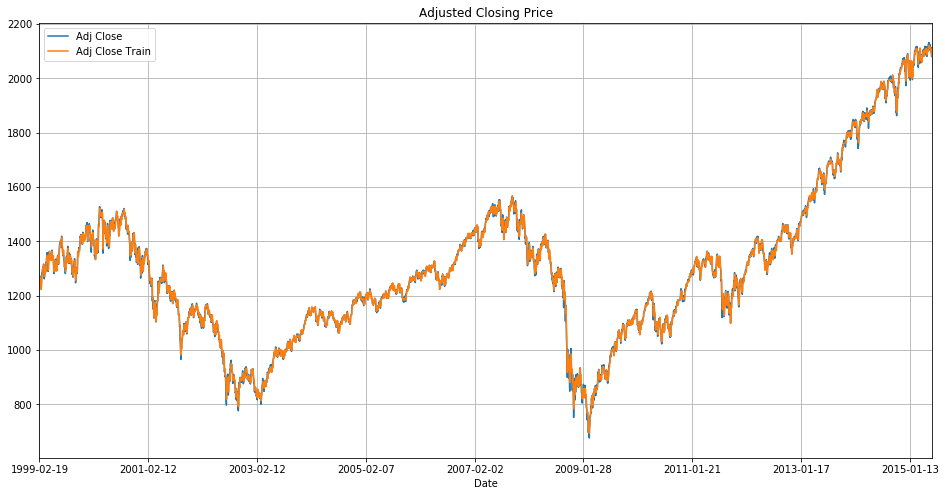

In [15]:
# Plot what it looks like for the training data
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_gb['Adj Close Train'] = y_pred_train_gb[:-window_size]
df_gb.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

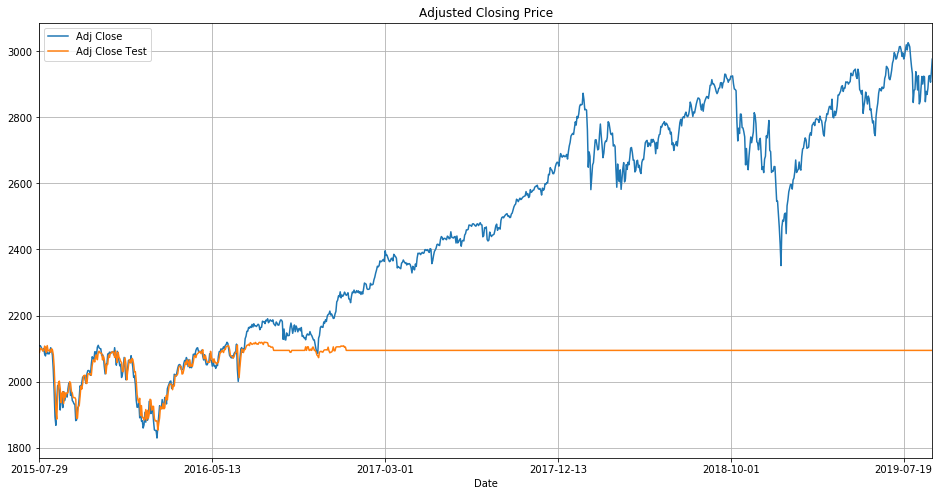

In [16]:
# run it on the test data
# Same for the test
df_gb = df.copy()
df_gb.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_gb = df_gb.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_gb['Adj Close Test'] = y_pred_gb
df_gb.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Not as good!

Now trying a neural network.

In [17]:
# Model #3 - Using RNNs
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])

keras_model.summary()

W0906 01:01:24.351103 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0906 01:01:24.392716 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0906 01:01:24.399223 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 32, 128)           768       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 32, 128)           82048     
_________________________________________________________________
lstm_1 (LSTM)                (None, 32, 128)           131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [18]:
# First figure out the right learning rate
lr_schedule = LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = SGD(lr=1e-8, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
# Scale the data due to LSTM units
scaler = MinMaxScaler(feature_range=(-1, 1))
data_transform = scaler.fit_transform(df['Adj Close'].values[:,None])
data_transform = data_transform[indices]
X2 = data_transform[:,:-1]
y2 = data_transform[:,-1]
X_train_reshape = X2[:ind_split]
y_train_reshape = y2[:ind_split]
X_test_reshape = X2[ind_split:]
y_test_reshape = y2[ind_split:]

W0906 01:01:29.927560 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [19]:
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, callbacks=[lr_schedule], validation_data=(X_test_reshape, y_test_reshape))


W0906 01:01:35.764221 140113081800576 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0906 01:01:36.921494 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0906 01:01:36.977003 140113081800576 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1020: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4136 samples, validate on 1034 samples
Epoch 1/250
4136/4136 [==============================] - 10s 3ms/step - loss: 0.1091 - mean_absolute_error: 0.4290 - val_loss: 0.1390 - val_mean_absolute_error: 0.4634
Epoch 2/250
4136/4136 [==============================] - 2s 457us/step - loss: 0.1091 - mean_absolute_error: 0.4290 - val_loss: 0.1390 - val_mean_absolute_error: 0.4634
Epoch 3/250
4136/4136 [==============================] - 2s 470us/step - loss: 0.1091 - mean_absolute_error: 0.4290 - val_loss: 0.1390 - val_mean_absolute_error: 0.4634
Epoch 4/250
4136/4136 [==============================] - 2s 458us/step - loss: 0.1091 - mean_absolute_error: 0.4290 - val_loss: 0.1390 - val_mean_absolute_error: 0.4634
Epoch 5/250
4136/4136 [==============================] - 2s 465us/step - loss: 0.1091 - mean_absolute_error: 0.4290 - val_loss: 0.1390 - val_mean_absolute_error: 0.4634
Epoch 6/250
4136/4136 [==============================] - 2s 469us/step - loss: 0.1091 - mean_absolute_error:

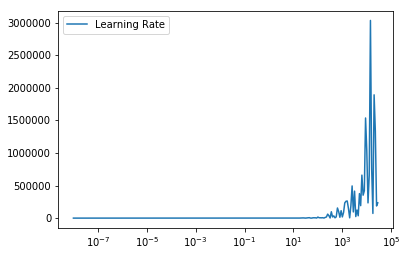

In [20]:
# let's do some plotting to figure out the best learning rate
plt.semilogx(history.history['lr'], history.history['val_loss'])
plt.legend(['Learning Rate', 'Validation Loss'])

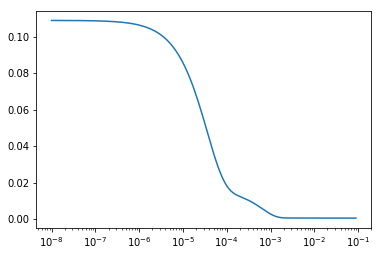

In [21]:
# and some more plotting
plt.semilogx(history.history['lr'][:140], history.history['loss'][:140])


Think I'm going to use a learning rate of 0.06

In [26]:
# Observing the above graph, 0.06 seems to be the best learning rate
keras_model = Sequential([
  Conv1D(filters=128, kernel_size=5, input_shape=(window_size, 1), strides=1, padding="causal", activation="tanh"),
  Conv1D(filters=128, kernel_size=5, strides=1, padding="causal", activation="tanh"),
  LSTM(128, return_sequences=True),
  LSTM(128),
  Dense(64, activation="tanh"),
  Dense(64, activation="tanh"),
  Dense(1)
])


optimizer = SGD(lr=0.06, momentum=0.9)
keras_model.compile(loss=Huber(),
                    optimizer=optimizer,
                    metrics=["mae"])
history = keras_model.fit(X_train_reshape, y_train_reshape, batch_size=256, epochs=250, validation_data=(X_test_reshape, y_test_reshape))

Train on 4136 samples, validate on 1034 samples
Epoch 1/250
4136/4136 [==============================] - 3s 815us/step - loss: 0.0363 - mean_absolute_error: 0.2189 - val_loss: 0.0226 - val_mean_absolute_error: 0.1745
Epoch 2/250
4136/4136 [==============================] - 2s 475us/step - loss: 0.0049 - mean_absolute_error: 0.0826 - val_loss: 0.0189 - val_mean_absolute_error: 0.1523
Epoch 3/250
4136/4136 [==============================] - 2s 476us/step - loss: 0.0013 - mean_absolute_error: 0.0403 - val_loss: 0.0134 - val_mean_absolute_error: 0.1259
Epoch 4/250
4136/4136 [==============================] - 2s 478us/step - loss: 6.0922e-04 - mean_absolute_error: 0.0264 - val_loss: 0.0188 - val_mean_absolute_error: 0.1524
Epoch 5/250
4136/4136 [==============================] - 2s 465us/step - loss: 5.2322e-04 - mean_absolute_error: 0.0246 - val_loss: 0.0189 - val_mean_absolute_error: 0.1530
Epoch 6/250
4136/4136 [==============================] - 2s 478us/step - loss: 4.9928e-04 - mean_ab

In [0]:
# now undo the normalization so I can plot predictions at the same scale as original values
y_pred_train_keras = scaler.inverse_transform(keras_model.predict(X_train_reshape, batch_size=256))
y_pred_keras = scaler.inverse_transform(keras_model.predict(X_test_reshape, batch_size=256))

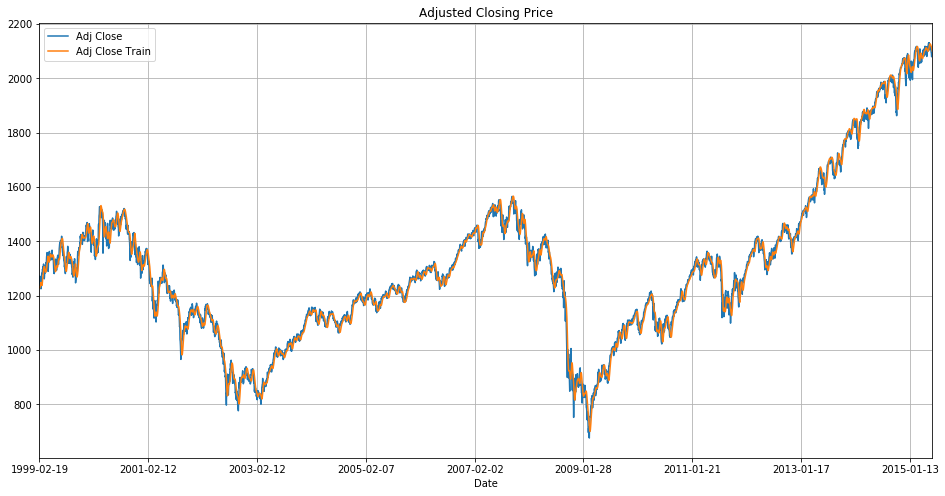

In [28]:
# Plot what it looks like for the training data
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_keras['Adj Close Train'] = y_pred_train_keras[:-window_size]
df_keras.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

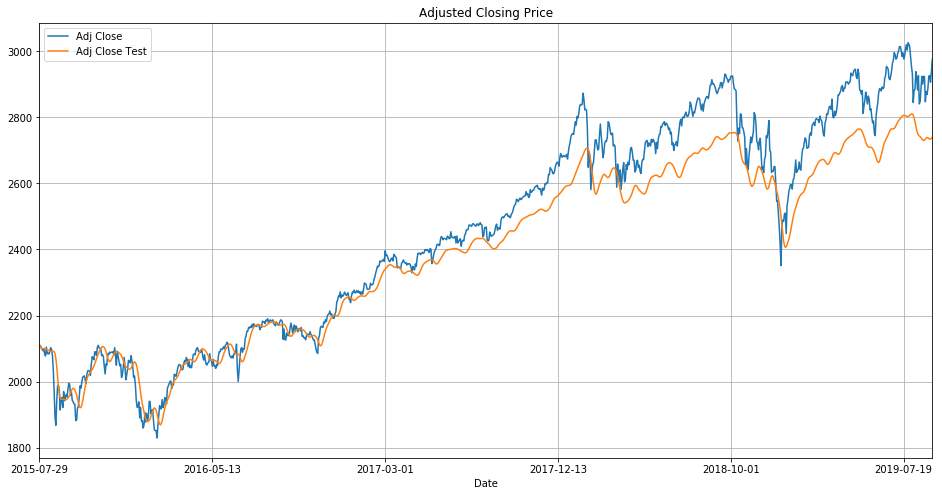

In [29]:
# Plot for the test
df_keras = df.copy()
df_keras.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_keras = df_keras.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_keras['Adj Close Test'] = y_pred_keras
df_keras.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

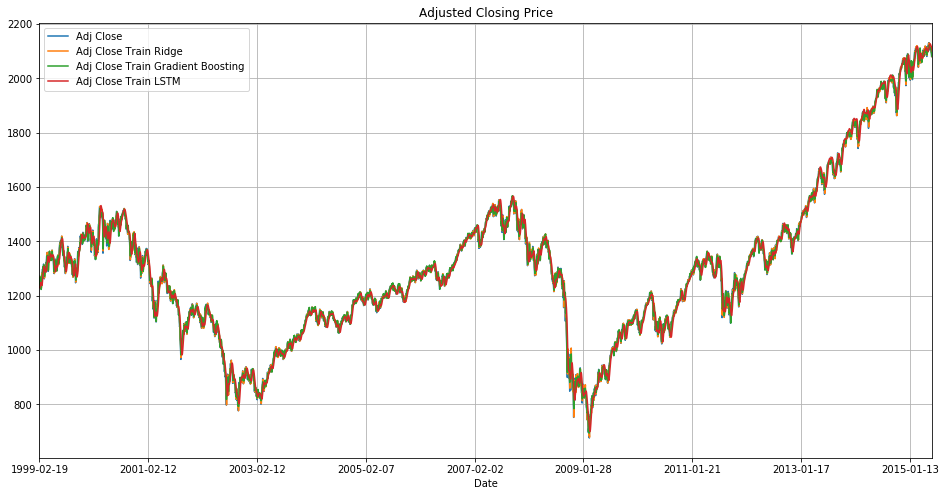

In [30]:
# now let's plot all the methods for training data
df_train = df.copy()
df_train.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_train = df_train.iloc[window_size:ind_split] # Past 32 days we don't know yet
# Add in all of our methods
df_train['Adj Close Train Ridge'] = y_pred_train_ridge[:-window_size]
df_train['Adj Close Train Gradient Boosting'] = y_pred_train_gb[:-window_size]
df_train['Adj Close Train LSTM'] = y_pred_train_keras[:-window_size]
# Plot the data now
df_train.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)

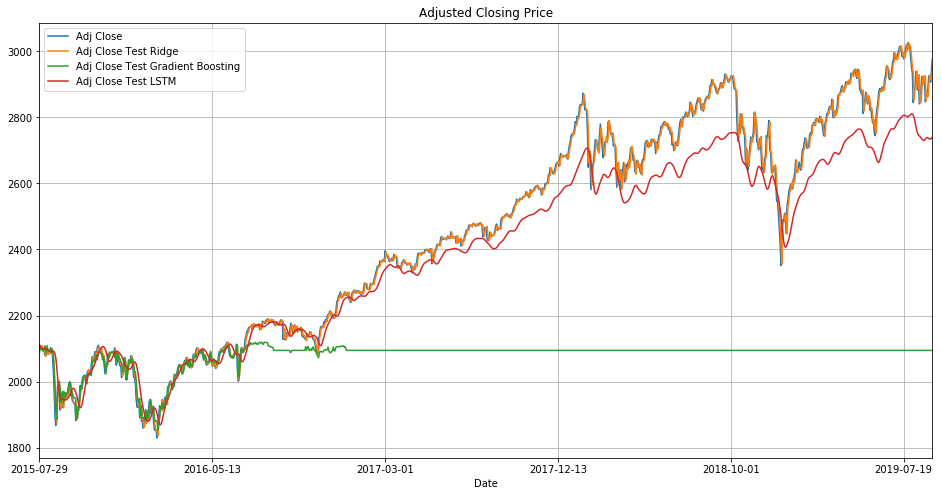

In [31]:
# and let's plot all the methods for the test data
df_test = df.copy()
df_test.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_test = df_test.iloc[ind_split+window_size:] # Past 32 days we don't know yet
# Add in all of our methods
df_test['Adj Close Test Ridge'] = y_pred_ridge
df_test['Adj Close Test Gradient Boosting'] = y_pred_gb
df_test['Adj Close Test LSTM'] = y_pred_keras
# Plot the data now
df_test.plot(label='SP500', figsize=(16,8), title='Adjusted Closing Price', grid=True)